In [1]:
from src.makedata import *
from src.makemodel import *
from src.time import *

In [10]:
# return dataloader for training/testing datasets, containing a dict of ["img"],["msk"],["name"] for each data point
batch = 8 # batch size in dataloader
dataname="dk8" 
phases=["train", "val"]  # dataset hdfs5 name format: dataname_phase, phase: train, val, test
shuffle = True 
dataLoader = {} # load data
for phase in phases:
    dataLoader[phase] = Data_Loader(dataname,phase,batch,shuffle) 
    dataset_size = len(dataLoader[phase])
    print('%s images = %d' % (phase, dataset_size))

train images = 752
val images = 752


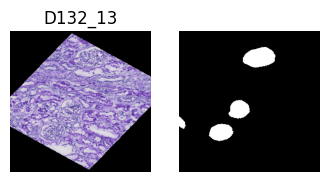

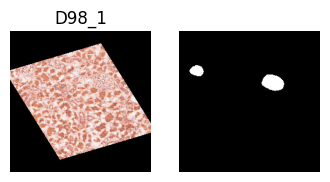

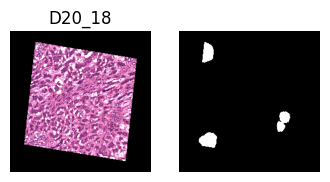

In [14]:
dataLoader["val"].vis_data() # visualize training patch with nonsclerotic glomeruli groundtruth mask   

In [15]:
isTrain = True  # set to False when using model in testing process
isContinue = True  # train from former saved model weights
savedir = "./log/"  # save path for model weights we want to save
loadpath = "dk8_UNet_norm_25x_pre249*.pth"  # loadpath for saved models for continue training or testing  
num_epochs = 1 # training epoches

In [16]:
# create/load model
model = GlomNet(isTrain, isContinue, savedir, loadpath, "UNet")

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
[CREATE] MODEL
UNet
[LOADED] MODEL


In [17]:
phases = ["train","val"]
start_time = time.time()
best_loss_on_test = np.Infinity
device = model.get_device()
#model.set_lr(0.0001) # default lr is 0.001, which can adjusted if want 

# start training 
for epoch in range(num_epochs):
    # accumulate loss for batches
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    
    for phase in phases:
        if phase == "train":
            model.set_train()  # set model to training mode
        else: 
            model.set_eval()  # set model to testing mode
        
        # for each of the batches
        for ii , data in enumerate(dataLoader[phase]): 
            # input batch image NXCXHXW and mask NxHXW
            model.set_input(data["img"],data["msk"])
            if phase == "train":
                model.forward()
                model.backward()
            else:
                model.validate() # enable no_grad, speed up
            all_loss[phase]=torch.cat((all_loss[phase],model.get_loss().detach().view(1,-1))) 
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
            epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")
    
    # save model weights with lowest validation loss
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        model.save_networks("UNet_nonscl_pre{}*.pth".format(epoch),epoch)
    else:
        print(" ")
    # simple learning rate linear decrease every 40 epoches, which can also be adjusted 
    if ((epoch+1)%40==0):
        model.update_lr()

0m 33s (- -1m 59s) ([1/1] 100%), train loss: 0.0261 test loss: 0.0230  **
